## Workflow

1. Retrieve STAC items for the population density collection and define an area of interest
2. Compute statistics for each time step using the `/statistics` endpoint
3. Visualize the resulting time series
4. Accelerate processing with parallel computation using Dask

The statistics endpoint is provided by the VEDA titiler implementation, which enables dynamic tile generation and data aggregation. While the API is publicly accessible, the underlying data may require authentication. The body of any request must remain under 16Kb, which can be limiting for complex geometries.

In [1]:
import json
import sys
import requests
import folium
import shapely

import pandas as pd
import matplotlib.pyplot as plt

## Configure the Data Collection

Explore available datasets through:

* **Programmatically**: See `list-collections.ipynb`
* **JSON API**: https://api.dev.veda.grss.cloud/stac/collections

In [2]:
STAC_API_URL = "https://api.dev.veda.grss.cloud/stac"
RASTER_API_URL = "https://api.dev.veda.grss.cloud/raster"

collection_id = "sedac-popdensity-yeargrid5yr-v4.11"

## Fetch Collection Metadata

Retrieve details about the population density collection including temporal extent and data format.

In [3]:
response = requests.get(f"{STAC_API_URL}/collections/{collection_id}")
assert response.ok, response.text

collection = response.json()
collection

{'id': 'sedac-popdensity-yeargrid5yr-v4.11',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/sedac-popdensity-yeargrid5yr-v4.11/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/sedac-popdensity-yeargrid5yr-v4.11'},
  {'rel': 'http://www.opengis.net/def/rel/ogc/1.0/queryables',
   'type': 'application/schema+json',
   'title': 'Queryables',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/sedac-popdensity-yeargrid5yr-v4.11/queryables'}],
 'title': 'SEDAC Gridded World Population Density v4.11',
 'assets': {},
 'extent': {'spatial': {'bbox': [[-180,
     -90,
     179.99999999999983,
     89.99999999999991]]

### Examine Temporal Properties

Check the periodic nature and temporal coverage of the dataset.

In [4]:
print(f"Periodic data: {collection.get('dashboard:is_periodic', 'N/A')}")
print(f"Time density: {collection.get('dashboard:time_density', 'N/A')}")
print(f"Temporal range: {collection.get('summaries', {}).get('datetime', 'N/A')}")

Periodic data: N/A
Time density: N/A
Temporal range: ['2000-01-01T00:00:00Z', '2005-01-01T00:00:00Z', '2010-01-01T00:00:00Z', '2015-01-01T00:00:00Z', '2020-01-01T00:00:00Z']


## Retrieve Available Items

Query all STAC items within the collection.

In [5]:
response = requests.get(
    f"{STAC_API_URL}/collections/{collection_id}/items",
    params={"limit": 100}
)
assert response.ok, response.text

items = response.json()["features"]
print(f"Retrieved {len(items)} items")

Retrieved 5 items


Inspect the structure of a single item:

In [6]:
items[0]

{'id': 'sedac-popdensity-yeargrid5yr-v4.11-gpw_v4_population_density_rev11_2020_30_sec_2020',
 'bbox': [-180.0, -90.0, 179.99999999999983, 89.99999999999991],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/sedac-popdensity-yeargrid5yr-v4.11'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/sedac-popdensity-yeargrid5yr-v4.11'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/sedac-popdensity-yeargrid5yr-v4.11/items/sedac-popdensity-yeargrid5yr-v4.11-gpw_v4_population_density_rev11_2020_30_sec_2020'},
  {'title': 'Map of Item',
   'href': 'https://api.dev.veda.grss.cloud/raster/collections/sedac-popdensity-yeargrid5yr-v4.11/items/sedac-popdensity-yeargrid5yr-v4.1

## Define Area of Interest

Create a bounding box covering the Indian subcontinent for population density analysis.

In [7]:
india_bbox = {
    "type": "Feature",
    "properties": {"name": "Indian Subcontinent"},
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [68.0, 8.0],
                [97.5, 8.0],
                [97.5, 35.5],
                [68.0, 35.5],
                [68.0, 8.0],
            ]
        ],
    },
}

In [8]:
m = folium.Map(
    location=[22, 82],
    zoom_start=4,
)

folium.GeoJson(india_bbox, name="Study Area").add_to(m)
m

## Calculate Zonal Statistics

Define a function to compute statistics for each item within the AOI.

In [9]:
def compute_stats(item, geojson):
    """Compute zonal statistics for a STAC item over a GeoJSON feature."""
    response = requests.post(
        f"{RASTER_API_URL}/collections/{collection_id}/items/{item['id']}/statistics",
        json=geojson
    )
    assert response.ok, response.text
    
    result = response.json()
    # Get the first asset's statistics
    stats_key = list(result["properties"]["statistics"].keys())[0]
    
    return {
        **result["properties"]["statistics"][stats_key],
        "datetime": item["properties"].get("datetime") or item["properties"].get("start_datetime"),
    }

Test the function on a single item:

In [10]:
%%time
compute_stats(items[0], india_bbox)

CPU times: user 14.8 ms, sys: 5.15 ms, total: 19.9 ms
Wall time: 6.89 s


{'min': 0.0,
 'max': 183500.984375,
 'mean': 319.87804557101936,
 'count': 7634679.0,
 'sum': 2442166197.0821047,
 'std': 994.8761041031477,
 'median': 134.92578125,
 'majority': 0.0,
 'minority': 1.2108720284231822e-06,
 'unique': 832856.0,
 'histogram': [[7630975, 3033, 339, 201, 93, 22, 8, 6, 0, 2],
  [0.0,
   18350.09765625,
   36700.1953125,
   55050.29296875,
   73400.390625,
   91750.484375,
   110100.5859375,
   128450.6875,
   146800.78125,
   165150.875,
   183500.984375]],
 'valid_percent': 65.32,
 'masked_pixels': 4054162.0,
 'valid_pixels': 7634679.0,
 'percentile_2': 0.0,
 'percentile_98': 1676.1239013671875,
 'datetime': '2020-01-01T00:00:00Z'}

### Process All Items

Gather statistics across the full temporal range.

In [11]:
%%time
stats = [compute_stats(item, india_bbox) for item in items]

CPU times: user 108 ms, sys: 19.6 ms, total: 128 ms
Wall time: 33.1 s


## Visualize Results

Convert statistics to a pandas DataFrame for easier manipulation.

In [12]:
df = pd.DataFrame(stats)
df["date"] = pd.to_datetime(df["datetime"])
df = df.sort_values("date")
df.head()

,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,datetime,date
4,0.0,91639.554688,229.666597,7634679.0,1.753431e+09,676.066884,106.107010,0.0,0.000001,832535.0,"[[7629171, 3259, 1697, 201, 69, 249, 15, 13, 3...",65.32,4054162.0,7634679.0,0.0,1207.834595,2000-01-01T00:00:00Z,2000-01-01 00:00:00+00:00
3,0.0,109011.375000,247.572055,7634679.0,1.890133e+09,726.471006,113.783066,0.0,0.000001,832324.0,"[[7630026, 2851, 1305, 175, 190, 104, 15, 11, ...",65.32,4054162.0,7634679.0,0.0,1292.039673,2005-01-01T00:00:00Z,2005-01-01 00:00:00+00:00
2,0.0,129676.320312,268.397970,7634679.0,2.049132e+09,790.871804,120.475212,0.0,0.000001,832717.0,"[[7630408, 3504, 321, 269, 130, 23, 16, 6, 0, ...",65.32,4054162.0,7634679.0,0.0,1402.566040,2010-01-01T00:00:00Z,2010-01-01 00:00:00+00:00
1,0.0,154258.656250,292.296563,7634679.0,2.231590e+09,873.666032,127.544792,0.0,0.000001,832952.0,"[[7630644, 3348, 430, 100, 116, 21, 12, 6, 0, ...",65.32,4054162.0,7634679.0,0.0,1535.461792,2015-01-01T00:00:00Z,2015-01-01 00:00:00+00:00
0,0.0,183500.984375,319.878046,7634679.0,2.442166e+09,994.876104,134.925781,0.0,0.000001,832856.0,"[[7630975, 3033, 339, 201, 93, 22, 8, 6, 0, 2]...",65.32,4054162.0,7634679.0,0.0,1676.123901,2020-01-01T00:00:00Z,2020-01-01 00:00:00+00:00


### Plot the Time Series

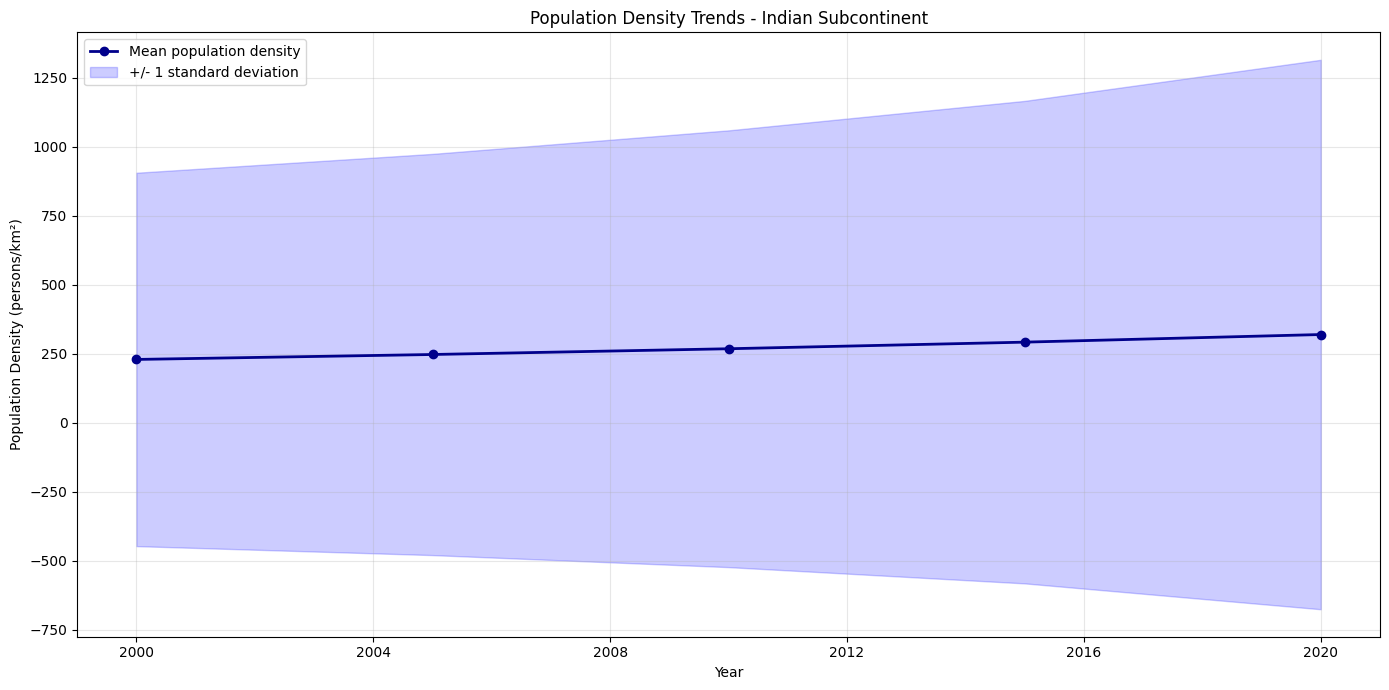

In [13]:
fig = plt.figure(figsize=(14, 7))

plt.plot(
    df["date"],
    df["mean"],
    color="darkblue",
    marker="o",
    linewidth=2,
    label="Mean population density"
)

plt.fill_between(
    df["date"],
    df["mean"] + df["std"],
    df["mean"] - df["std"],
    alpha=0.2,
    color="blue",
    label="+/- 1 standard deviation"
)

plt.xlabel("Year")
plt.ylabel("Population Density (persons/km²)")
plt.title("Population Density Trends - Indian Subcontinent")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

The time series reveals population growth patterns across the region over the available data period.